In [1]:
from regression_toolbox.model import Model, add_model, delete_model
from regression_toolbox.likelihood import Likelihood
from regression_toolbox.parameter import Parameter
from visualisation_toolbox.domain import Domain
from regression_toolbox.sampler import Sampler
from visualisation_toolbox.visualiser import Visualiser, GPVisualiser, RegressionVisualiser
from data_processing.sim_data_processor import SimDataProcessor
from data_processing.raw_data_processor import RawDataProcessor
from gaussian_process_toolbox.kernel import Kernel
from gaussian_process_toolbox.gaussian_processor import GP
import numpy as np
import pandas as pd
import os
import jax

os.chdir('/PhD_project/')

jax.config.update("jax_enable_x64", True)


/build/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from gaussian_process_toolbox.kernel import Kernel

# Define a spatiotemporal kernel configuration
kernel_config = {
    ('matern', 'xy'): [0, 1],  # Apply Matern kernel to spatial dimensions (latitude, longitude)
    ('rbf', 't'): [2]          # Apply RBF kernel to temporal dimension (time)
}

# Create kernel instance
kernel_obj = Kernel(kernel_config, kernel_concatination='*')

# Set kernel parameters
kernel_obj.add_kernel_param('matern', 'xy', 'length_scale', [1.5, 1.5])
kernel_obj.add_kernel_param('matern', 'xy', 'nu', 1.5)  # Smoothness parameter
kernel_obj.add_kernel_param('rbf', 't', 'length_scale', 2.0)

# Retrieve the kernel
gp_kernel = kernel_obj.get_kernel()

# Generate synthetic training data: 50 samples in (latitude, longitude, time)
X_train = np.random.rand(50, 3)
y_train = np.sin(X_train[:, 0]) + np.cos(X_train[:, 1]) + 0.1 * X_train[:, 2]

# Fit a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

# Predict on new data
X_test = np.random.rand(5, 3)
y_pred, y_std = gp.predict(X_test, return_std=True)

print("Predictions:", y_pred)
print("Prediction Standard Deviations:", y_std)
print("Optimized Kernel:", gp.kernel_)


Predictions: [1.01910136 1.21070013 1.04539243 1.41781341 1.50567398]
Prediction Standard Deviations: [0.00221891 0.00080689 0.00376177 0.00243644 0.00121534]
Optimized Kernel: _KernelTransformer(2.24, 2.13) * _KernelTransformer(3.16)


In [4]:
# Define a multi-Matern kernel configuration
kernel_config = {
    ('matern', 'spatial'): [0, 1],  # Matern kernel for depth and distance
    ('matern', 'temporal'): [2]     # Separate Matern kernel for time
}

# Create kernel instance
kernel_obj = Kernel(kernel_config, kernel_concatination='*')

# Set kernel parameters
kernel_obj.add_kernel_param('matern', 'spatial', 'length_scale', [3.0, 3.0])
kernel_obj.add_kernel_param('matern', 'spatial', 'nu', 0.5)  # Rougher process
kernel_obj.add_kernel_param('matern', 'temporal', 'length_scale', 5.0)
kernel_obj.add_kernel_param('matern', 'temporal', 'nu', 1.5)  # Smoother process

# Retrieve the kernel
gp_kernel = kernel_obj.get_kernel()

# Generate synthetic training data: 100 samples (depth, distance, time)
X_train = np.random.rand(100, 3)
y_train = np.sin(X_train[:, 0]) * np.cos(X_train[:, 1]) + 0.2 * X_train[:, 2]

# Fit Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

# Predict on new data
X_test = np.random.rand(10, 3)
y_pred, y_std = gp.predict(X_test, return_std=True)

print("Predictions:", y_pred)
print("Prediction Standard Deviations:", y_std)
print("Optimized Kernel:", gp.kernel_)


Predictions: [0.12254521 0.75497281 0.48695723 0.2800973  0.6624361  0.23210442
 0.5376154  0.62848486 0.54308221 0.28525522]
Prediction Standard Deviations: [0.00917054 0.02223652 0.01418869 0.01256066 0.02059822 0.0253829
 0.01644405 0.0123037  0.01467664 0.01192826]
Optimized Kernel: _KernelTransformer(5.24, 6.06) * _KernelTransformer(2.81)


Constructed Kernel: _KernelTransformer(0.405) + _KernelTransformer(0)
Predictions: [ 0.54755493  0.5919761   0.63569979  0.67827423  0.71923067  0.75808849
  0.79436087  0.82756079  0.85720744  0.88283286  0.90398876  0.9202533
  0.93123793  0.93659393  0.9360187   0.92926159  0.91612923  0.89649013
  0.87027856  0.83749762  0.79822125  0.75259536  0.70083789  0.6432377
  0.58015249  0.51200557  0.43928164  0.36252151  0.28231593  0.19929863
  0.11413856  0.02753162 -0.05980817 -0.14715774 -0.23379421 -0.31900415
 -0.40209273 -0.48239244 -0.55927146 -0.6321414  -0.70046425 -0.7637586
 -0.82160484 -0.87364933 -0.91960762 -0.9592664  -0.99248447 -1.01919253
 -1.03939195 -1.05315243]
Prediction Standard Deviations: [0.26148837 0.23744077 0.21531214 0.19531738 0.17765008 0.16246513
 0.14985428 0.13981814 0.1322435  0.126898   0.12345023 0.12151179
 0.12068727 0.12061634 0.12099919 0.12160534 0.12227045 0.12288676
 0.12339133 0.12375446 0.1239697  0.12404573 0.12400029 0.12385587
 0.1236370

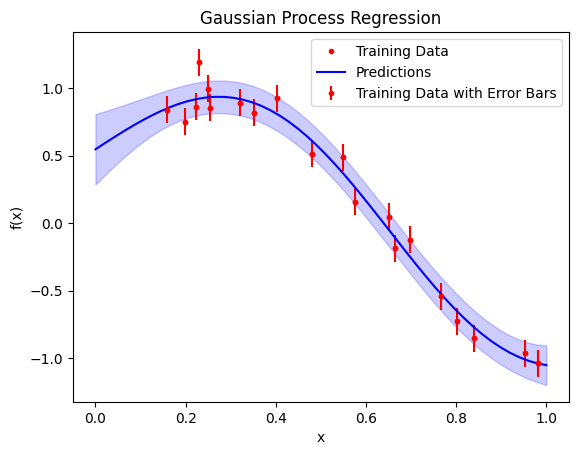

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor

# Define kernel configuration for a single RBF kernel applied to 'x' (dimension index 0)
kernel_config = {('rbf', 'x'): [0],
                 ('white', 'x'): [0]}

# Create kernel instance
kernel_obj = Kernel(kernel_config)

# Set kernel parameters
kernel_obj.add_kernel_param('rbf', 'x', 'length_scale', 1.5)

# Retrieve the kernel
gp_kernel = kernel_obj.get_kernel()
print(f"Constructed Kernel: {gp_kernel}")

# Generate synthetic training data
X_train = np.random.rand(20, 1)  # 20 samples, 1D input (since we're using only 'x')
# Generate synthetic training data with noise
y_train = np.sin(5 * X_train).flatten() + 0.1 * np.random.randn(20)

# Fit a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

# Predict on new data
X_test = np.linspace(0, 1, 50).reshape(-1, 1)  # 50 test points
y_pred, y_std = gp.predict(X_test, return_std=True)

# Print results
print("Predictions:", y_pred)
print("Prediction Standard Deviations:", y_std)
print("Optimized Kernel:", gp.kernel_)


plt.figure()
plt.plot(X_train, y_train, 'r.', label='Training Data')
plt.errorbar(X_train, y_train, yerr=0.1, fmt='r.', label='Training Data with Error Bars')
plt.plot(X_test, y_pred, 'b-', label='Predictions')
plt.fill_between(X_test.flatten(), y_pred - y_std, y_pred + y_std, alpha=0.2, color='blue')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()


In [6]:
sim_model = Model('line').add_fixed_model_param('a', 1).add_fixed_model_param('b', 1)
sim_domain = Domain(1, 'linear').add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 50)
sim_domain.build_domain()

sim_data_processor = SimDataProcessor('gp_test_1', sim_model, sim_domain, noise_dist='gaussian', noise_level=1)

# Define kernel configuration with Matern kernel applied to 'x' (dimension index 0)
kernel_config = {
    ('matern', 'x'): [0],  # Replace 'rbf' with 'matern'
    ('white', 'x'): [0]     # Keep WhiteKernel for noise handling
}

# Create kernel instance with sensible hyperparameters
kernel_obj = Kernel(kernel_config) \
    .add_kernel_param('matern', 'x', 'length_scale', 1.0) \
    .add_kernel_param('matern', 'x', 'nu', 1.5) \
    .add_kernel_param('white', 'x', 'noise_level', 1) \


# Train the GP model with the new kernel
gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

# Create a domain for visualization
vis_domain = Domain(1, 'linear').add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 1000)
vis_domain.build_domain()

# Visualize the results
visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title='GP Test 4 (Matern Kernel)', plot_type='1D')


Data loaded from /PhD_project/data/processed_sim_data/gp_test_1
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_1
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_1/instance_1/gaussian_process_model.pkl


In [7]:
sim_model = Model('parabaloid').add_fixed_model_param('a', 3).add_fixed_model_param('b', 1)
sim_domain = Domain(2, 'rectangular').add_domain_param('min_x', -10).add_domain_param('max_x', 10).add_domain_param('min_y', -10).add_domain_param('max_y', 10).add_domain_param('n_points_x', 40).add_domain_param('n_points_y', 40)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_2', sim_model, sim_domain,noise_dist='gaussian' ,noise_level=1)

kernel_config = {('matern', 'xy'): [0, 1]}

kernel_obj = Kernel(kernel_config).add_kernel_param('matern', 'xy', 'length_scale', [1, 1])
kernel_obj.add_kernel_param('matern', 'xy', 'nu', 2.5)
kernel_obj.add_kernel_param('matern', 'xy', 'length_scale_bounds', [(0.1, 10), (0.1,10)])


gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(2, 'circular').add_domain_param('radius', 5).add_domain_param('mass', 10000)
vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title = 'GP Test 5', plot_type='2D')




Data loaded from /PhD_project/data/processed_sim_data/gp_test_2
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_2
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_2/instance_1/gaussian_process_model.pkl


In [8]:
# add_model('test2D', 'A*sin(x/a)*cos(y/b) + B*exp(-(x^2 + y^2)/c^2)', ['x', 'y'], 'C', ['A', 'B', 'a', 'b', 'c'])

sim_model = Model('test2D').add_fixed_model_param('A', 1).add_fixed_model_param('B', 2).add_fixed_model_param('a', 3).add_fixed_model_param('b', 4).add_fixed_model_param('c', 5)
sim_domain = Domain(2, 'rectangular').add_domain_param('min_x', -10).add_domain_param('max_x', 10).add_domain_param('min_y', -10).add_domain_param('max_y', 10).add_domain_param('n_points_x', 60).add_domain_param('n_points_y', 60)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_3', sim_model, sim_domain,noise_dist='gaussian' ,noise_level=1)

kernel_config = {('matern', 'xy'): [0, 1]}

kernel_obj = Kernel(kernel_config).add_kernel_param('matern', 'xy', 'length_scale', [1, 1])
kernel_obj.add_kernel_param('matern', 'xy', 'nu', 1.5)
kernel_obj.add_kernel_param('matern', 'xy', 'length_scale_bounds', [(0.01, 100), (0.01,100)])


gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(2, 'circular').add_domain_param('radius', 5).add_domain_param('mass', 10000)
vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title = 'GP Test 5', plot_type='2D')




Data loaded from /PhD_project/data/processed_sim_data/gp_test_3
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_3
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_3/instance_1/gaussian_process_model.pkl


In [9]:
# add_model('ellipsoid3D', 'A * exp(-(x^2/a^2 + y^2/b^2 + z^2/c^2))', 
#           ['x', 'y', 'z'], 'D', ['A', 'a', 'b', 'c'])


sim_model = Model('ellipsoid3D').add_fixed_model_param('A', 1).add_fixed_model_param('a', 3).add_fixed_model_param('b', 4).add_fixed_model_param('c', 5)
sim_domain = Domain(3, 'cuboidal').add_domain_param('min_x', -10).add_domain_param('max_x', 10).add_domain_param('min_y', -10).add_domain_param('max_y', 10).add_domain_param('n_points_x', 10).add_domain_param('n_points_y', 10).add_domain_param('min_z', -10).add_domain_param('max_z', 10).add_domain_param('n_points_z', 10)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_6', sim_model, sim_domain,noise_dist='gaussian' ,noise_level=0.1)

kernel_config = {('matern', 'xyz'): [0, 1, 2]}

kernel_obj = Kernel(kernel_config).add_kernel_param('matern', 'xyz', 'length_scale', [1, 1, 1])
kernel_obj.add_kernel_param('matern', 'xyz', 'nu', 2.5)
kernel_obj.add_kernel_param('matern', 'xyz', 'length_scale_bounds', (0.01, 100))

gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(3, 'spherical').add_domain_param('radius', 5).add_domain_param('mass', 10000)
vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title = 'GP Test 5', plot_type='3D')
visualiser.show_predictions(vis_domain, 'test', title = 'GP Test 5', plot_type='3D_recursive')

Data loaded from /PhD_project/data/processed_sim_data/gp_test_6
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_6
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_6/instance_1/gaussian_process_model.pkl


In [10]:
# add_model('wave1D', 'A * sin(2 * pi * (x / a - t / b))', 
#           ['x', 't'], 'D', ['A', 'a', 'b'])
 
sim_model = Model('wave1D').add_fixed_model_param('A', 1).add_fixed_model_param('a', 3).add_fixed_model_param('b', 4)
sim_domain = Domain(1, 'linear', time_array = np.linspace(0.5,5,10), dim_names=['x', 't']).add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 50)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_7', sim_model, sim_domain,noise_dist='gaussian' ,noise_level=0.1)

kernel_config = {('matern', 'x'): [0], ('rbf', 't'): [1]}
kernel_obj = Kernel(kernel_config).add_kernel_param('matern', 'x', 'length_scale', 1.5)
kernel_obj.add_kernel_param('rbf', 't', 'length_scale', 2.0)

gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(1, 'linear', time_array = np.linspace(0.5,5,10), dim_names=['x', 't']).add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 100)
vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title = 'GP Test 5', plot_type='1D_time')

Data loaded from /PhD_project/data/processed_sim_data/gp_test_7
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_7
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_7/instance_1/gaussian_process_model.pkl


In [11]:
# add_model('wave2D', 'A * sin(2 * pi * (x / a + y / b - t / c))', 
#           ['x', 'y', 't'], 'D', ['A', 'a', 'b', 'c'])

sim_model = Model('wave2D') \
    .add_fixed_model_param('A', 1) \
    .add_fixed_model_param('a', 3) \
    .add_fixed_model_param('b', 4) \
    .add_fixed_model_param('c', 5)

sim_domain = Domain(2, 'rectangular', time_array=np.linspace(0, 5, 10), dim_names=['x', 'y', 't']) \
    .add_domain_param('min_x', 0).add_domain_param('max_x', 10).add_domain_param('n_points_x', 15) \
    .add_domain_param('min_y', 0).add_domain_param('max_y', 10).add_domain_param('n_points_y', 15)

sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_8', sim_model, sim_domain, noise_dist='gaussian', noise_level=0.1)

kernel_config = {('matern', 'xy'): [0, 1], ('rbf', 't'): [2]}
kernel_obj = Kernel(kernel_config) \
    .add_kernel_param('matern', 'xy', 'length_scale', [1.5, 1.5]) \
    .add_kernel_param('matern', 'xy', 'nu', 1.5) \
    .add_kernel_param('matern', 'xy', 'length_scale_bounds', (0.1, 10)) \
    .add_kernel_param('rbf', 't', 'length_scale', 2.0) \
    .add_kernel_param('rbf', 't', 'length_scale_bounds', (0.1, 10))

gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(2, 'rectangular', time_array=np.linspace(0, 5, 10), dim_names=['x', 'y', 't']) \
    .add_domain_param('min_x', 0).add_domain_param('max_x', 10).add_domain_param('n_points_x', 30) \
    .add_domain_param('min_y', 0).add_domain_param('max_y', 10).add_domain_param('n_points_y', 30)

vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title='GP Test 2D Time', plot_type='2D_time')


Data loaded from /PhD_project/data/processed_sim_data/gp_test_8
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_8
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_8/instance_2/gaussian_process_model.pkl


In [ ]:
# add_model('wave3D', 'A * exp(-((x/a)^2 + (y/b)^2 + (z/c)^2)) * sin(2 * pi * (t / d))', 
#           ['x', 'y', 'z', 't'], 'D', ['A', 'a', 'b', 'c', 'd'])

sim_model = Model('wave3D') \
    .add_fixed_model_param('A', 1) \
    .add_fixed_model_param('a', 3) \
    .add_fixed_model_param('b', 4) \
    .add_fixed_model_param('c', 5) \
    .add_fixed_model_param('d', 6)

sim_domain = Domain(3, 'cuboidal', time_array=np.linspace(0, 5, 10), dim_names=['x', 'y', 'z', 't']) \
    .add_domain_param('min_x', -5).add_domain_param('max_x', 5).add_domain_param('n_points_x', 10) \
    .add_domain_param('min_y', -5).add_domain_param('max_y', 5).add_domain_param('n_points_y', 10) \
    .add_domain_param('min_z', -5).add_domain_param('max_z', 5).add_domain_param('n_points_z', 10)

sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_9', sim_model, sim_domain, noise_dist='gaussian', noise_level=0.1)

kernel_config = {('matern', 'xyz'): [0, 1, 2], ('rbf', 't'): [3]}
kernel_obj = Kernel(kernel_config) \
    .add_kernel_param('matern', 'xyz', 'length_scale', [1.5, 1.5, 1.5]) \
    .add_kernel_param('matern', 'xyz', 'nu', 1.5) \
    .add_kernel_param('matern', 'xyz', 'length_scale_bounds', (0.1, 10)) \
    .add_kernel_param('rbf', 't', 'length_scale', 2.0) \
    .add_kernel_param('rbf', 't', 'length_scale_bounds', (0.1, 10))

gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(3, 'cuboidal', time_array=np.linspace(0, 5, 10), dim_names=['x', 'y', 'z', 't']) \
    .add_domain_param('min_x', -5).add_domain_param('max_x', 5).add_domain_param('n_points_x', 30) \
    .add_domain_param('min_y', -5).add_domain_param('max_y', 5).add_domain_param('n_points_y', 30) \
    .add_domain_param('min_z', -5).add_domain_param('max_z', 5).add_domain_param('n_points_z', 30)

vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title='GP Test 3D Time', plot_type='3D_time')


Data generated and saved to /PhD_project/data/processed_sim_data/gp_test_9
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_9


In [ ]:
processor_params = {
    'identifier': 'aves',
    'tax_group': 'class',
    'num_x_cells': 10,
    'num_y_cells': 10,
    'timestep': 'year'
}

raw_data_processor = RawDataProcessor('xylo_test_project', 'xylo_test_2', 'XYLO_processor', processor_params)
raw_data_processor.process_data()
